# Cat Facts Application

Bu uygulama, aşağıdaki adımları içermektedir:

1. **API İsteği**: "https://cat-fact.herokuapp.com/facts" adresindeki API'ye bir GET isteği gönderin ve dönen JSON verisini alın.
2. **Veritabanı Oluşturma**: Alınan veriyi saklamak için bir SQLite veritabanı oluşturun. Bu veritabanında, kedi fact’lerini saklayacak bir tablo bulunmalıdır.
3. **Veri Kaydetme**: API'den alınan kedi fact’lerini SQLite veritabanına kaydedin.
4. **Veri Görüntüleme**: Veritabanına kaydedilen kedi fact’lerini terminal/powershell'de görüntüleyin.


## Gerekli Kütüphanelerin Yüklenmesi

In [1]:
!pip install requests plotly pandas



In [2]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 25.2 MB/s eta 0:00:00


In [16]:
import requests
import pandas as pd
import sqlite3
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 1. API İsteği

Cat Facts API'den veri almak için bir GET isteği gönderiyoruz.


In [4]:
# 1. Adım: API İsteği
url = "https://cat-fact.herokuapp.com/facts"
response = requests.get(url)

if response.status_code == 200:
    cat_facts = response.json()
    print("Veriler başarıyla alındı.")
else:
    print(f"API isteği başarısız oldu. Durum kodu: {response.status_code}")
    cat_facts = None

Veriler başarıyla alındı.


## 2. Veritabanı Oluşturma

Alınan verileri saklamak için bir SQLite veritabanı oluşturuyoruz.


In [5]:
# 2. Adım: Veritabanı Oluşturma ve Verileri Kaydetme
if cat_facts:
    # Veritabanı bağlantısı ve tablo oluşturma
    conn = sqlite3.connect('cat_facts.db')
    c = conn.cursor()

    c.execute('''
              CREATE TABLE IF NOT EXISTS facts
              (id TEXT PRIMARY KEY,
               text TEXT,
               created_at TEXT)
              ''')

    # Veritabanına verileri kaydetme
    for fact in cat_facts:
        c.execute('''
                  INSERT OR REPLACE INTO facts (id, text, created_at)
                  VALUES (?, ?, ?)
                  ''', (fact['_id'], fact['text'], fact['createdAt']))

    conn.commit()
    print("Veriler veritabanına başarıyla kaydedildi.")
    conn.close()
else:
    print("Veri alınamadı, lütfen daha sonra tekrar deneyin.")

Veriler veritabanına başarıyla kaydedildi.


## 3. Verilerin Görselleştirilmesi

Veritabanına kaydedilen verileri pandas DataFrame'e dönüştürüyoruz ve ardından Plotly Express ile görselleştiriyoruz.


In [6]:
conn = sqlite3.connect('cat_facts.db')
c = conn.cursor()
c.execute('SELECT * FROM facts')
rows = c.fetchall()

# Pandas DataFrame'e dönüştürme
df = pd.DataFrame(rows, columns=["ID", "Fact", "Created At"])

# Tarih formatını dönüştürme
df['Created At'] = pd.to_datetime(df['Created At'])
df['Fact Length'] = df['Fact'].apply(len)

conn.close()

# Veritabanındaki verilerin gösterilmesi
print(df)

                         ID  \
0  58e008780aac31001185ed05   
1  58e009390aac31001185ed10   
2  588e746706ac2b00110e59ff   
3  58e008ad0aac31001185ed0c   
4  58e007cc0aac31001185ecf5   

                                                Fact  \
0  Owning a cat can reduce the risk of stroke and...   
1  Most cats are lactose intolerant, and milk can...   
2  Domestic cats spend about 70 percent of the da...   
3  The frequency of a domestic cat's purr is the ...   
4  Cats are the most popular pet in the United St...   

                        Created At  Fact Length  
0 2018-03-29 20:20:03.844000+00:00           71  
1 2018-03-04 21:20:02.979000+00:00          183  
2 2018-01-14 21:20:02.750000+00:00           92  
3 2018-03-15 20:20:03.281000+00:00           96  
4 2018-03-01 21:20:02.713000+00:00          102  


### Plotly Express ile Görselleştirme

Bu bölümde, SQLite veritabanına kaydedilen kedi bilgilerini görselleştireceğiz. Verileri pandas DataFrame'e dönüştürdükten sonra, `plotly.express` kullanarak çeşitli grafikler oluşturacağız. Bu grafikler, verilerin farklı yönlerini analiz etmemize olanak tanır.

In [27]:
custom_colors = ['#00ff00', '#00cc00', '#009900', '#006600', '#003300']
layout = go.Layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    width=800,
    height=400
)
pio.renderers.default = "svg"

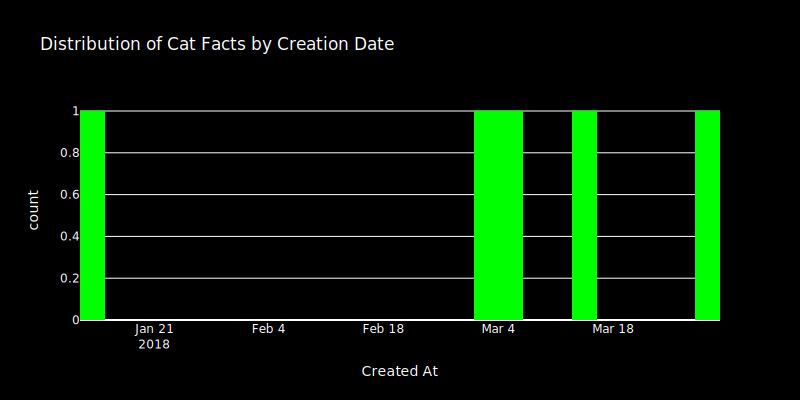

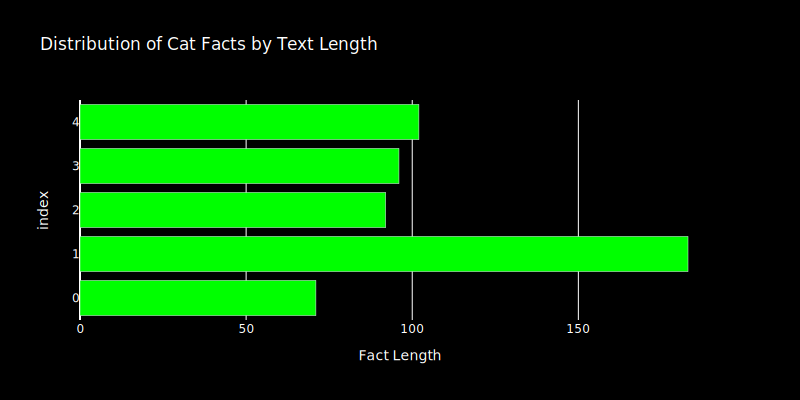

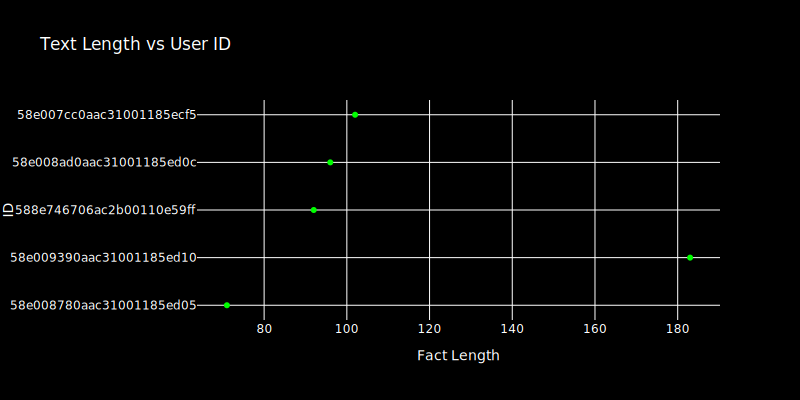

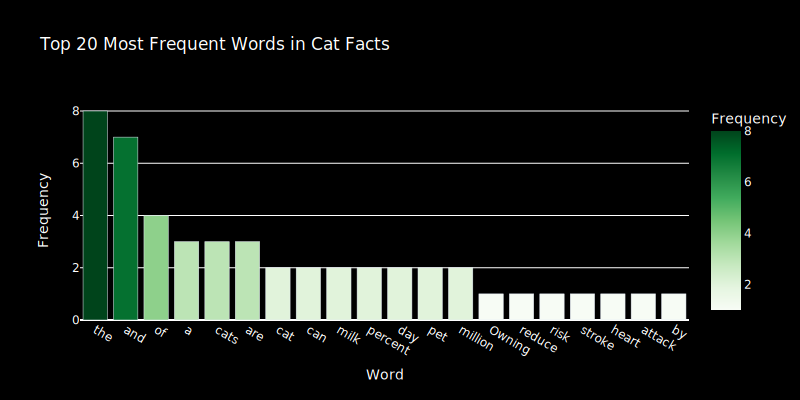

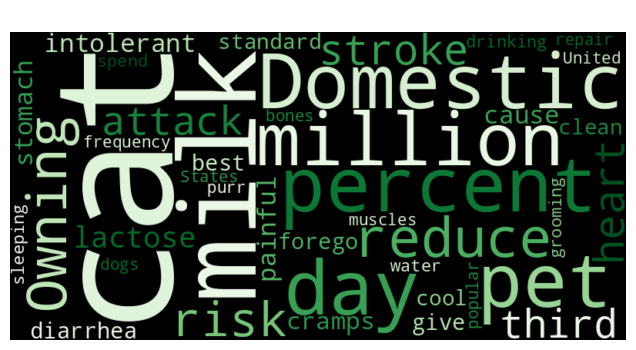

In [35]:
# 1. Histogram: Oluşturulma tarihine göre kedi bilgileri
fig_hist = px.histogram(df, x='Created At', nbins=30, title='Distribution of Cat Facts by Creation Date',
                        color_discrete_sequence=custom_colors)
fig_hist.update_layout(layout)
fig_hist.show()

# 2. Bar Grafik: Kedi bilgileri metin uzunluklarının dağılımı
fig_bar = px.bar(df, x='Fact Length', title='Distribution of Cat Facts by Text Length',
                 color_discrete_sequence=custom_colors)
fig_bar.update_layout(layout)
fig_bar.show()

# 3. Scatter Plot: Metin Uzunluğu ve Kullanıcı ID'si
fig_scatter = px.scatter(df, x='Fact Length', y='ID', title='Text Length vs User ID',
                         color_discrete_sequence=custom_colors)
fig_scatter.update_layout(layout)
fig_scatter.show()

# 5. Kelime Sıklığı Histogramı
all_text = " ".join(df['Fact'])  # Tüm metinleri birleştir
words = all_text.split()  # Kelimelere ayır
word_counts = Counter(words)  # Kelime sayımı
common_words = word_counts.most_common(20)  # En yaygın 20 kelime

word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

fig_word_freq = px.bar(word_freq_df, x='Word', y='Frequency', title='Top 20 Most Frequent Words in Cat Facts',
                       color='Frequency', color_continuous_scale='Greens')
fig_word_freq.update_layout(layout)
fig_word_freq.show()

# 6. Kelime Bulutu
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Greens').generate(all_text)

plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Cat Facts Word Cloud", color='white')
plt.show()